One of the strengths of this model is the ability to be customized. Since every person has differences in cooking preferences, methods for considering other objectives should also be considered. This report looks into the linear program treated as a tradeoff problem. The tradeoff term is arbitrary. For demonstration's sake, a new array is used to quantify the deliciousness of each recipe from 1-10. The model considers the tradeoff of optimizing for maximum deliciousness versus minimum cost.

There is one more data array to be considered.

\begin{align}
D_r, \text{ the deliciousness of ingredient r, } \forall r \in R \\
\lambda, \text{ the tradeoff parameter that weighs the importance of cost relative to deliciousness}
\end{align}

This additional objective only changes the objective function. The new objective function becomes:

\begin{align}
\min \sum_{t \in T, i \in I} x_{ti}*C_i - \lambda * \sum_{t \in T, r \in R} D_r * y_{tr}
\end{align}

Any[193.5163205863682, 275.33392342348435, 491.32097126662063, 512.8956285359224, 2105.1617867975497, 2735.053897338291, 3111.8902207470023, 3111.8902207470023, 3877.2781114192885, 4921.363510849598, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103651, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 7296.455294103652, 72

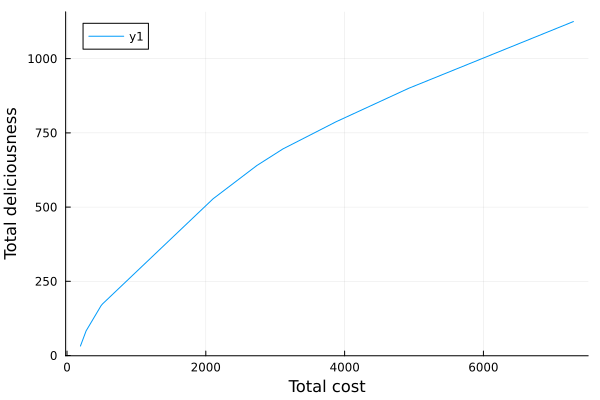

In [30]:
using Random, NamedArrays, Plots

T_end = 10
T = 1:T_end
FR_CAP = 100

#Data 2:
Random.seed!(300)
I = [:rice, :chicken_nuggets, :steak, :noodles, :cream, :tomato]
N = [:calories, :protein]
R = [:steak_and_rice, :just_nuggets, :chicken_marinara, :steak_alfredo]
Req = NamedArray([5 0 3 0 0 0; 0 10 0 0 0 0; 0 2 0 5 0 3; 0 0 3 5 2 0], (R, I), ("Recipes", "Ingredients")) 
F = NamedArray([300 0; 200 5; 400 30; 300 5; 200 10; 100 1], (I, N), ("Ingredients", "Nutrients"))
S = NamedArray([2000, 100], N, "Nutrient Requirements")
C = NamedArray(zeros(Float64, length(T), length(I)), (T, I), ("Week", "Ingredients"))
V = NamedArray([20, 20, 40, 50, 20, 20], I, "Volume")
D = NamedArray([9, 5, 7, 2], R, "Deliciousness") 

for i in 1:length(I)
    C[1, i] = length(String(I[i]))
end

for t in 2:length(T)
    for i in 1:length(I)
        C[t, i] = C[t - 1, i] + 2 * Random.randn() + .05 * C[t - 1, i]
        if C[t, i] <= 1
            C[t, i] = 1.0
        end
    end
end


# make the model
using JuMP, HiGHS

cost_list = []
delic_list = []

function run_model(lam)
    m = Model(HiGHS.Optimizer)

    @variable(m, x[T, I] >= 0)
    @variable(m, y[T, R] >= 0)
    @variable(m, z[T, I] >= 0)

    @constraint(m, nutr_satisfied[n in N, t in T],
        sum(y[t, r] * sum(Req[r, i] * F[i, n] for i in I) for r in R) >= S[n])

    @constraint(m, fridge_capacity[t in T], sum( x[t, i] for i in I ) <= FR_CAP)

    @constraint(m, first_ingredient_bal[i in I], x[1, i] == sum( y[1,r] * Req[r,i] for r in R) + z[1, i])

    @constraint(m, ingredient_bal[t in 2:T_end, i in I], x[t, i] + z[t-1, i] == sum( y[t,r] * Req[r,i] for r in R) + z[t, i])

    @objective(m, Max, - sum( x[t, i] * C[t, i] for i in I, t in T ) + lam * sum(y[t,r]*D[r] for t in T, r in R) )

    set_silent(m)
    optimize!(m)

    x_end = value.(x)
    y_end = value.(y)

    cost = sum( x_end[t, i] * C[t, i] for i in I, t in T )
    deliciousness = sum(y_end[t,r]*D[r] for t in T, r in R)

    push!(cost_list, cost)
    push!(delic_list, deliciousness)
end

for lambda in 1:1:200
    run_model(lambda)
end

println(cost_list)
println(delic_list)

plot(cost_list, delic_list, xlabel="Total cost", ylabel="Total deliciousness")

Another interesting situation to consider when making this model is when a person's situation does not have an optimal solution. For example, there are many college students with small fridges that may not be able to hold enough food to meet all of the nutrient requirements. This is the example that will be analyzed but there are many other situations. Some people may have dietary restrictions that do not allow them to feasibly meet some nutrition requirements or there may be others who have a maximum budget that does not allow the nutrient requirements to be satisfied. The question in these situations then becomes how to minimize the error or how to get as close as possible to fulfilling all constraints.